In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from image_similarity_measures.quality_metrics import fsim, issm, sam, ssim, uiq, psnr
from sewar import full_ref as sfr
from patchify import patchify, unpatchify
from tqdm.notebook import trange, tqdm
from Util.pyDialogue import askFILE

In [ ]:
def eval_fromPatches(file, patchsize:tuple = (256,256)):
    results = {}

    file = np.load(file=file).astype(np.uint8)
    num_features = file.shape[2]//2

    for i in range(num_features):
        results[f'feature_{i}'] = {}

    eval_cases = [np.dstack([file[...,i], file[...,i+int(num_features)]]) for i in range(num_features)]
    
    for i, eval_case in tqdm(enumerate(eval_cases), desc = 'Evaluating...', total = num_features):
        gt_patches = patchify(eval_case[...,0], patchsize, patchsize[0])
        pred_patches = patchify(eval_case[...,1], patchsize, patchsize[0])
        
        for r in trange(gt_patches.shape[0]):
            for k in trange(gt_patches.shape[1]):
                col =  {
                    'PSNR':[],
                    'SSIM':[], 
                    'MSSSIM':[]}
                
                col['PSNR'] = psnr(gt_patches[r,k,...][...,None],pred_patches[r,k,...][...,None], 255)
                col['SSIM'] = ssim(gt_patches[r,k,...][...,None],pred_patches[r,k,...][...,None], 255)
                col['MSSSIM'] = np.abs(sfr.msssim(gt_patches[r,k,...][...,None],pred_patches[r,k,...][...,None], MAX = 255))
                
                results[f'feature_{i}'][f"({r},{k})"] = col
                
    return results

In [ ]:
num_features = 2
average = {}
img_l = np.load(img)

for i in range(num_features):
    average[f'feature_{i}'] = None

for i, key in enumerate(average.keys()):
    average[key] = {
        'PSNR':psnr(img_l[...,i][...,None], img_l[...,i+num_features][...,None], 255),
        'SSIM':ssim(img_l[...,i][...,None], img_l[...,i+num_features][...,None], 255),  
        'MSSSIM':np.abs(sfr.msssim(img_l[...,i][...,None], img_l[...,i+num_features][...,None], MAX = 255))}
print(average)

In [ ]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [ ]:
def highlight(file, eval, color_by, background:str = 'ground_truth', patchsize:tuple = (256,256)):
    file = np.load(file=file).astype(np.uint8)
    num_features = file.shape[2]//2

    eval_cases = [np.dstack([file[...,i], file[...,i+int(num_features)]]) for i in range(num_features)]
    fig, ax = plt.subplots(1,3,dpi = 300, figsize = (15,5))
    plt.style.use('dark_background')
    
    for i, eval_case in enumerate(eval_cases):
        if background == 'ground_truth':
            background_patched = patchify(eval_case[...,0], patchsize, patchsize[0])
        elif background == 'prediction':
            background_patched = patchify(eval_case[...,1], patchsize, patchsize[0])
        color_patches = np.zeros_like(background_patched)
        
        if background == "ground_truth":
            ax[i].set_title(f"FeatGT #{i}")
            ax[i].imshow(eval_case[...,0], cmap = 'gray')
            
        elif background == 'prediction':
            ax[i].set_title(f"FeatSeg #{i}")
            ax[i].imshow(eval_case[...,1], cmap = 'gray')
        
        for r in range(color_patches.shape[0]):
            for k in range(color_patches.shape[1]):
                color_patches[r,k,...] = np.full(shape=patchsize, fill_value=np.floor(255*(eval[f"feature_{i}"][f"({r},{k})"][color_by])))
                
        img = ax[i].imshow(unpatchify(color_patches,(color_patches.shape[0]*color_patches.shape[2],color_patches.shape[1]*color_patches.shape[3])), alpha=0.35, cmap = 'Oranges_r')
        plt.colorbar(img, ax = ax[i])


    plt.show()

In [ ]:
highlight(img, eval, 'MSSSIM', 'ground_truth')

In [ ]:
highlight(img, eval, 'MSSSIM', 'prediction')

In [72]:
def highlight_both(file, eval, color_by, patchsize:tuple = (256,256)):
    file = np.load(file=file).astype(np.uint8)
    num_features = file.shape[2]//2

    eval_cases = [np.dstack([file[...,i], file[...,i+int(num_features)]]) for i in range(num_features)]
    fig, ax = plt.subplots(2,num_features,dpi = 300, figsize = (25,10))
    plt.style.use('default')
    
    for a in ax:
        for b in a:
            b.axis('off')
    
    for i, eval_case in enumerate(eval_cases):
        
        background_patched = patchify(eval_case[...,0], patchsize, patchsize[0])
        color_patches = np.zeros_like(background_patched)
        
        ax[0][i].set_title(f"FeatGT #{i}")
        ax[0][i].imshow(eval_case[...,0], cmap = 'gray')
        
        ax[1][i].set_title(f"FeatSeg #{i}")
        ax[1][i].imshow(eval_case[...,1], cmap = 'gray')
        
        for r in range(color_patches.shape[0]):
            for k in range(color_patches.shape[1]):
                color_patches[r,k,...] = np.full(shape=patchsize, fill_value=np.floor(255*(eval[f"feature_{i}"][f"({r},{k})"][color_by])))
                
        img1 = ax[0][i].imshow(unpatchify(color_patches,(color_patches.shape[0]*color_patches.shape[2],color_patches.shape[1]*color_patches.shape[3])), alpha=0.35, cmap = 'YlOrRd_r')
        plt.colorbar(img1, ax = ax[0][i])
        
        img2 = ax[1][i].imshow(unpatchify(color_patches,(color_patches.shape[0]*color_patches.shape[2],color_patches.shape[1]*color_patches.shape[3])), alpha=0.35, cmap = 'YlOrRd_r')
        plt.colorbar(img2, ax = ax[1][i])


    plt.savefig(f'./patchedEval_{color_by}.png', transparent = True)
    return eval_cases

In [70]:
img = askFILE()
eval = eval_fromPatches(img, patchsize=(64,64))

Evaluating...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [68]:
import json

with open('SHARELOC_64x64px.txt', 'w') as file:
    file.write(json.dumps(eval, indent=6))

In [69]:
col_SSIM = {}
col_MSSSIM = {}
for key in eval.keys():
    
    SSIM_feat = [subentry['SSIM'] for subentry in [entry for entry in eval[key].values()]]
    MSSSIM_feat = [subentry['MSSSIM'] for subentry in [entry for entry in eval[key].values()]]
    col_SSIM[key] = SSIM_feat
    col_MSSSIM[key] = MSSSIM_feat

with open('SHARELOC_64x64px_SSIM.txt', 'w') as file:
    file.write(json.dumps(col_SSIM, indent=6))
    
with open('SHARELOC_64x64px_MSSSIM.txt', 'w') as file:
    file.write(json.dumps(col_MSSSIM, indent=6))

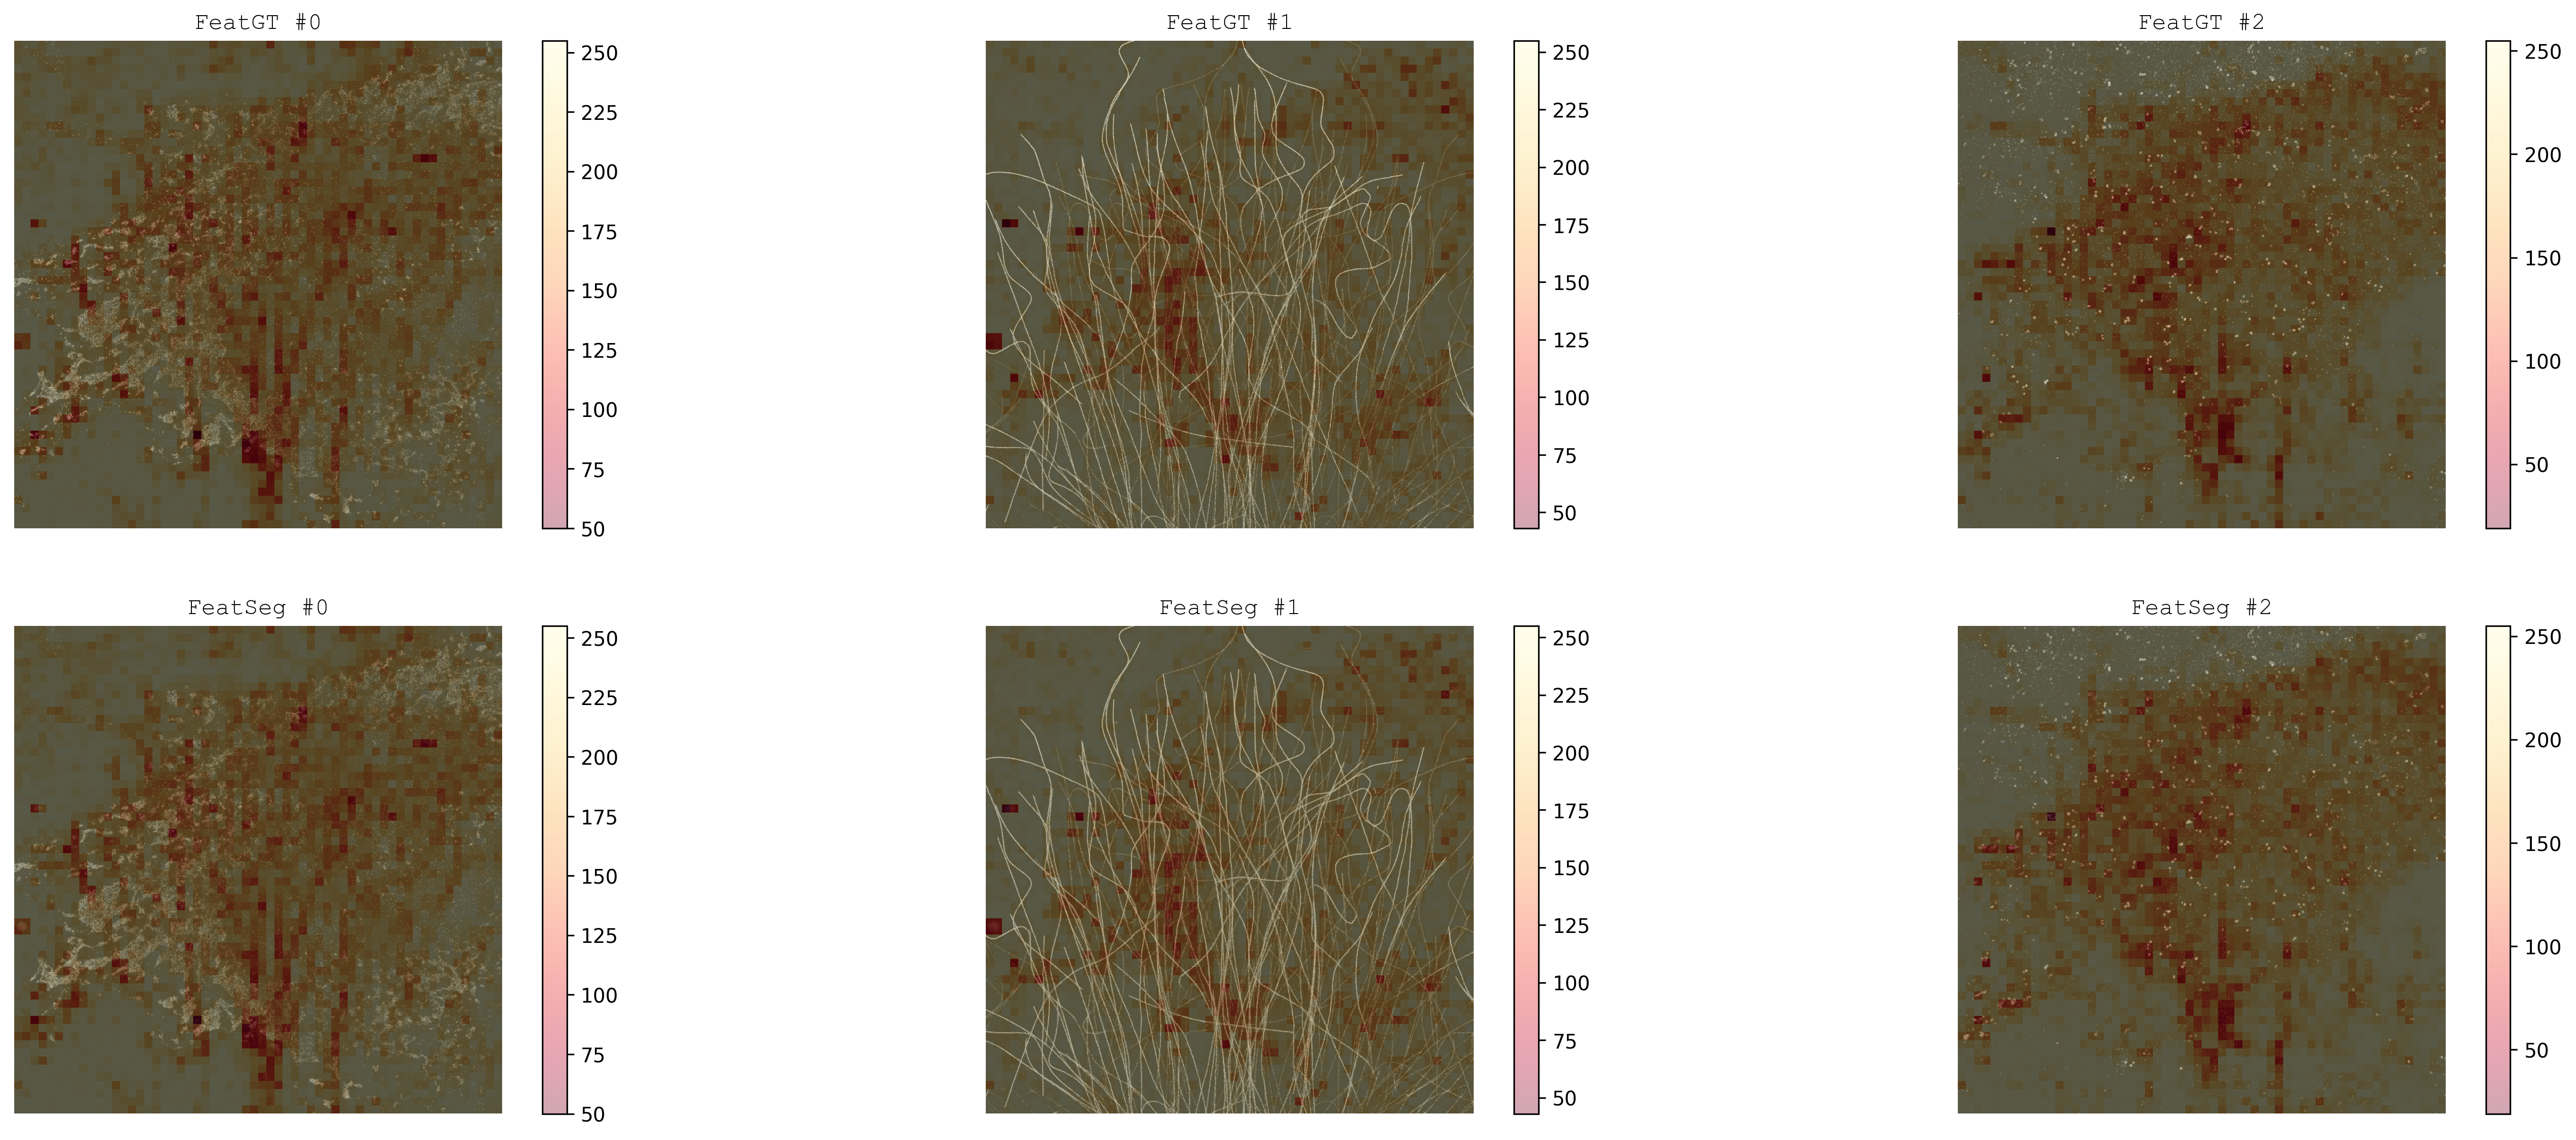

In [73]:
eval_cases = highlight_both(img, eval, 'SSIM', (64,64))

In [ ]:
highlight_both(img, eval, 'MSSSIM', (64,64))

In [42]:
def hist_from_metric(eval, n_features:int = 3, kernel:str = '32x32'):
    col_SSIM = []
    col_MSSSIM = []
    for key in eval.keys():
        
        SSIM_feat = [subentry['SSIM'] for subentry in [entry for entry in eval[key].values()]]
        MSSSIM_feat = [subentry['MSSSIM'] for subentry in [entry for entry in eval[key].values()]]
        col_SSIM.append(SSIM_feat)
        col_MSSSIM.append(MSSSIM_feat)
    col_SSIM = np.array(col_SSIM).swapaxes(0,1)
    col_MSSSIM = np.array(col_MSSSIM).swapaxes(0,1)
        
    import matplotlib
    from matplotlib.ticker import PercentFormatter
    font = {'family' : 'Courier new',
            'weight' : 'bold',
            'size'   : 10}

    matplotlib.rc('font', **font)
    
    plt.figure(figsize = (8,4), dpi = 200)
    plt.xlabel('SSIM [a.u.]', font = font)
    plt.hist(col_SSIM, bins = 25, histtype='bar', label = [f"{key}" for key in eval.keys()], weights=np.ones_like(col_SSIM) / len(col_SSIM))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(loc = 'best', shadow = True, fancybox = True, framealpha=0.0)
    plt.savefig(f'SSIM_hist_{kernel}px_legend.png', bbox_inches = 'tight', transparent=True)
    plt.close()
    
    plt.figure(figsize = (8,4), dpi = 200)
    plt.xlabel('SSIM [a.u.]', font = font)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.hist(col_SSIM, bins = 25, histtype='bar', label = [f"{key}" for key in eval.keys()], weights=np.ones_like(col_SSIM) / len(col_SSIM))
    plt.savefig(f'SSIM_hist_{kernel}px_NO_legend.png', bbox_inches = 'tight', transparent=True)
    plt.close()
    
    plt.figure(figsize = (8,4), dpi = 200)
    plt.xlabel('MSSSIM [a.u.]', font = font)
    plt.hist(col_MSSSIM, bins = 25, histtype='bar', label = [f"{key}" for key in eval.keys()], weights=np.ones_like(col_MSSSIM) / len(col_MSSSIM))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(loc = 'best', shadow = True, fancybox = True, framealpha=0.0)
    plt.savefig(f'MSSSIM_hist_{kernel}px_legend.png', bbox_inches = 'tight', transparent=True)
    plt.close()
    
    plt.figure(figsize = (8,4), dpi = 200)
    plt.xlabel('MSSSIM [a.u.]', font = font)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.hist(col_MSSSIM, bins = 25, histtype='bar', label = [f"{key}" for key in eval.keys()], weights=np.ones_like(col_MSSSIM) / len(col_MSSSIM))
    plt.savefig(f'MSSSIM_hist_{kernel}px_NO_legend.png', bbox_inches = 'tight', transparent=True)
    plt.close()

In [50]:
hist_from_metric(eval=eval, n_features= 3, kernel='Würzburg_32x32')

In [ ]:
from PIL import Image
def extract_patch(eval_case, coord:tuple = (0,0), patchsize = (512,512)):
    col = []
    for i, eval_case in enumerate(eval_cases):
        
        gt = patchify(eval_case[...,0], patchsize, patchsize[0])
        seg = patchify(eval_case[...,1], patchsize, patchsize[0])
        
        gt_im = Image.fromarray(gt[coord[0], coord[1],...])
        seg_im = Image.fromarray(seg[coord[0], coord[1],...])
        
        gt_im.save("WU_patch_feature-{}_gt__SSIM-{:0.2f}__MSSSIM-{:0.2f}__.png".format(i,eval[f'feature_{i}'][f'({coord[0]},{coord[1]})']['SSIM'], eval[f'feature_{i}'][f'({coord[0]},{coord[1]})']['MSSSIM']))
        seg_im.save("WU_patch__feature-{}__SSIM-{:0.2f}__MSSSIM-{:0.2f}__.png".format(i,eval[f'feature_{i}'][f'({coord[0]},{coord[1]})']['SSIM'], eval[f'feature_{i}'][f'({coord[0]},{coord[1]})']['MSSSIM']))
        col.append(seg[coord[0], coord[1],...])
    
    col = np.sum(np.array(col), axis=0)
    col = col/np.max(col) * 255
    comb_seg = Image.fromarray(col.astype('uint8'))
    comb_seg.save("WU_Hara_patch_comb.png")

In [ ]:
extract_patch(eval_case=eval_cases, coord=(2,3))

In [ ]:
def extract_patch_from_gt(file, coord:tuple = (0,0), patchsize = (512,512)):
    img = np.load(file=file).astype('uint8')
    im = Image.fromarray(patchify(img[0,...], patch_size=patchsize, step=patchsize[0])[coord[0], coord[1],...])
    im.save("WU_gt_comb_patch.png")

In [ ]:
extract_patch_from_gt(askFILE(), coord=(2,3))

In [ ]:
test = np.load(askFILE())

In [ ]:
from skimage.io import imread

In [ ]:
Image.fromarray(imread(askFILE())[:512,:512]).save('FMX_Original.png')

In [ ]:
test.shape

In [ ]:
for i in range(3):
    im = Image.fromarray(test[...,i])
    im.save(f"MFX_{i}.png")

In [ ]:
np.load(askFILE()).shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from skimage.io import imread
from matplotlib_scalebar.scalebar import ScaleBar
def extract_patch_from_image(file, gt_file, num_feature, coord:tuple = (0,0), patchsize:tuple = (512,512), render_overview:bool = True):
    img = np.load(file)
    gt = np.load(gt_file)
    #gt = imread(gt_file)[:512,:512]
    
    gt_patches = patchify(gt, patch_size=patchsize, step=patchsize[0])
    
    for i in range(num_feature):
        patches = patchify(img[...,i], patch_size=patchsize, step=patchsize[0])
        Image.fromarray(patches[coord[0], coord[1],...]).save(f'Image_feature-{i}.png')
    Image.fromarray(gt_patches[coord[0], coord[1],...]).convert('L').save(f'Image_GT.png')
    
    if render_overview:
        plt.style.use('dark_background')
        font = {'family' : 'Courier new',
                'weight' : 'bold',
                'size'   : 12}
        matplotlib.rc('font', **font)
        fig, ax = plt.subplots(1,num_feature+1, figsize = (5*(num_feature+1), 5), dpi = 300)
        ax[0].axis('off')
        ax[0].imshow(gt, cmap = 'gray')
        ax[0].set_title('Ground Truth')
        ax[0].add_artist(ScaleBar(10, units='nm', location = 'lower right', frameon=0, color = 'w'))
        
        for i, label in zip(range(1,num_feature+1),['ER', 'MIC', 'CLA']):
            ax[i].axis('off')
            ax[i].imshow(img[...,i-1], cmap = 'gray')
            ax[i].set_title(f"Segmentation {label}")
            ax[i].add_artist(ScaleBar(10, units='nm', location = 'lower right', frameon=0, color = 'w'))
        
        plt.savefig('./Image_Overview.png', transparent = True)

In [ ]:
extract_patch_from_image(askFILE(), askFILE(), 3, (3,3), patchsize=(512,512), render_overview = True)